In [1]:
import os
import rasterio as rio
import numpy as np
import shapely
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array
import matplotlib as mpl
from matplotlib.colors import TwoSlopeNorm, LogNorm
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import sklearn
from cmcrameri import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import sys
sys.path.append('../')
import snowFun

In [2]:
import importlib
importlib.reload(snowFun)

<module 'snowFun' from 'C:\\Users\\lzell\\OneDrive - Colostate\\Desktop\\AGVA\\scripts\\Figures\\..\\snowFun\\__init__.py'>

In [3]:
# define folder and file paths
folder_AGVA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"AGVA")
folder_dems = os.path.join(folder_AGVA, "DEMs", "time_varying_DEMs", "10m")
folder_class = os.path.join(folder_AGVA, 'classified images', 'S2_Classified_Cloudmasked_Merged')
folder_cloud = os.path.join(folder_AGVA, 'classified images', 'S2_Cloud_Merged')
folder_meta = os.path.join(folder_AGVA, "classified images", "meta csv", "S2")
folder_climate = os.path.join(folder_AGVA, "Climate")

# open rgi
path_rgi = os.path.join(folder_AGVA, 'RGI', "rgi_2km_o3regions", "rgi_2km_o3regions.shp")
rgi_gdf = gpd.read_file(path_rgi, include_fields=['RGIId', 'geometry'])

# open the big data csv
path_data = os.path.join(folder_AGVA, 'Derived products', 'S2', 'Final_Data_Table.csv')
data_df = pd.read_csv(path_data)

# subset rgi to the glaciers we have data for
rgi_gdf = rgi_gdf[ rgi_gdf['RGIId'].isin(data_df['RGIId']) ]
# print(rgi_gdf.columns)

# merge columns
all_data_gdf = gpd.GeoDataFrame(pd.merge(data_df, rgi_gdf, on="RGIId"))

# replace -9999 with nan
all_data_gdf[all_data_gdf==-9999] = np.nan

# replace "True" and "False" with 1/0
all_data_gdf.replace({"False": 0, "True": 1}, inplace=True)

# what columns are available?
print(all_data_gdf.shape)
print(all_data_gdf.columns.values)

(3002, 82)
['RGIId' 'GLIMSId' 'BgnDate' 'EndDate' 'CenLon' 'CenLat' 'O1Region'
 'O2Region' 'Area' 'Zmin' 'Zmax' 'Zmed' 'Slope' 'Aspect' 'Lmax' 'Status'
 'Connect' 'Form' 'TermType' 'Surging' 'Linkages' 'Name' 'O3Region'
 'O3_name' 'ela_2018' 'ela_2019' 'ela_2020' 'ela_2021' 'ela_2022'
 'aar_2018' 'aar_2019' 'aar_2020' 'aar_2021' 'aar_2022' 'off_glacier_2018'
 'off_glacier_2019' 'off_glacier_2020' 'off_glacier_2021'
 'off_glacier_2022' 'date_2018' 'date_2019' 'date_2020' 'date_2021'
 'date_2022' 'ela_avg_product' 'aar_avg_product' 'aar_infill_avg_product'
 'off_glacier_avg_product' 'percent_observed_average_product' 'dhdt_1520'
 'dhdt_1020' 'distance_from_ocean' 'hyps_ela' 'hyps_aar' 'hyps_aar_20'
 'hyps_aar_40' 'hyps_aar_60' 'hyps_aar_80' 'hyps_aar_100' 'hyps_aar_120'
 'hyps_aar_140' 'hyps_aar_160' 'hyps_aar_180' 'hyps_aar_200'
 'hyps_aar_220' 'hyps_aar_240' 'hyps_aar_260' 'hyps_aar_280'
 'hyps_aar_300' 'hyps_aar_320' 'hyps_aar_340' 'hyps_aar_360'
 'hyps_aar_380' 'hyps_aar_400' 'hyps_a

In [4]:
### calculate each glacier's ELA, AAR variation from ela_avg_product in each year
# note that AAR can be calculated as magnitude or percent
for y in [2018,2019,2020,2021,2022]:
    all_data_gdf[f"ela_anom_{y}"] = all_data_gdf[f"ela_{y}"]-all_data_gdf["ela_avg_product"]
    all_data_gdf[f"aar_anom_{y}_mag"] = all_data_gdf[f"aar_{y}"]-all_data_gdf["aar_avg_product"]
    all_data_gdf[f"aar_anom_{y}_per"] = all_data_gdf[f"aar_anom_{y}_mag"]/all_data_gdf["aar_avg_product"]

# calculate the range in ela, aar that each glacier exhibits
all_data_gdf[f"ela_range"] = all_data_gdf[[f"ela_anom_{y}" for y in range(2018,2023)]].max(axis=1) - all_data_gdf[[f"ela_anom_{y}" for y in range(2018,2023)]].min(axis=1)
all_data_gdf[f"aar_range_mag"] = all_data_gdf[[f"aar_anom_{y}_mag" for y in range(2018,2023)]].max(axis=1) - all_data_gdf[[f"aar_anom_{y}_mag" for y in range(2018,2023)]].min(axis=1)
all_data_gdf[f"aar_range_per"] = all_data_gdf[[f"aar_anom_{y}_per" for y in range(2018,2023)]].max(axis=1) - all_data_gdf[[f"aar_anom_{y}_per" for y in range(2018,2023)]].min(axis=1)

In [5]:
# add column for accumulation area of each glacier
all_data_gdf['aa_avg_product'] = all_data_gdf['aar_infill_avg_product']*all_data_gdf['Area']

# add column for the total glacier area in each O2Region
temp = all_data_gdf.groupby('O2Region')['Area'].sum().rename('O2Region_area')
all_data_gdf = gpd.GeoDataFrame(pd.merge(all_data_gdf, temp, on="O2Region"))

# add column for the total glacier area in each O3Region
temp = all_data_gdf.groupby('O3Region')['Area'].sum().rename('O3Region_area')
all_data_gdf = gpd.GeoDataFrame(pd.merge(all_data_gdf, temp, on="O3Region"))

for y in [2018,2019,2020,2021,2022]:
    all_data_gdf[f"aa_{y}"] = all_data_gdf[f"aar_{y}"]*all_data_gdf['Area']

In [6]:
print('Range, ela (median):',round(np.nanmedian(all_data_gdf[f"ela_range"][all_data_gdf[f"ela_range"]>0]),1))
print('Standard deviation of ela range:',round(np.nanstd(all_data_gdf[f"ela_range"][all_data_gdf[f"ela_range"]>0]),1))
print('percentile 2,25,50,75,98, ela range:',np.nanpercentile(all_data_gdf[f"ela_range"][all_data_gdf[f"ela_range"]>0],[2,25,50,75,98]))
print()
print('Range, aar (median):',round(np.nanmedian(all_data_gdf[f"aar_range_mag"][all_data_gdf[f"ela_range"]>0]),3))
print('Standard deviation of ela range:',round(np.nanstd(all_data_gdf[f"aar_range_mag"][all_data_gdf[f"ela_range"]>0]),3))
print('percentile 2,25,50,75,98, aar range:',np.round( np.nanpercentile(all_data_gdf[f"aar_range_mag"][all_data_gdf[f"ela_range"]>0], [2,25,50,75,98]),3))
print('Range, aar:',round(np.nanmean(all_data_gdf[f"aar_range_per"][all_data_gdf[f"ela_range"]>0]),3),"%")
print()
print('2018:',round(np.nanmedian(all_data_gdf[f"ela_anom_2018"][all_data_gdf[f"ela_range"]>0]),1))
print('2019:',round(np.nanmedian(all_data_gdf[f"ela_anom_2019"][all_data_gdf[f"ela_range"]>0]),1))
print('2020:',round(np.nanmedian(all_data_gdf[f"ela_anom_2020"][all_data_gdf[f"ela_range"]>0]),1))
print('2021:',round(np.nanmedian(all_data_gdf[f"ela_anom_2021"][all_data_gdf[f"ela_range"]>0]),1))
print('2022:',round(np.nanmedian(all_data_gdf[f"ela_anom_2022"][all_data_gdf[f"ela_range"]>0]),1))

Range, ela (median): 470.5
Standard deviation of ela range: 267.4
percentile 2,25,50,75,98, ela range: [  98.48  330.    470.5   646.25 1185.7 ]

Range, aar (median): 0.459
Standard deviation of ela range: 0.203
percentile 2,25,50,75,98, aar range: [0.102 0.299 0.459 0.616 0.859]
Range, aar: 30.52 %

2018: 0.0
2019: 140.0
2020: -10.0
2021: -90.0
2022: -20.0


In [7]:
all_aars = []
for y in [2018,2019,2020,2021,2022]:
    subset = all_data_gdf[ ~np.isnan(all_data_gdf[f'aar_{y}']) ]
    aa_y = np.nansum(subset[f'aar_{y}']*subset[f'Area']) 
    area_y = np.nansum(subset[f'Area']) 
    aar_y = aa_y/area_y
    print(y, len(subset), round(aa_y), round(area_y), round(aar_y,3) )
    all_aars.append(aar_y)
print(np.nanmean(all_aars))
#     all_data_gdf['aar_infill_avg_product']*all_data_gdf['Area']

2018 2978 28456 76107 0.374
2019 2978 19162 76154 0.252
2020 2938 33988 75872 0.448
2021 2970 36984 76114 0.486
2022 2963 35906 76088 0.472
0.4062581344205302


In [8]:
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'

In [9]:
# fig,axs = snowFun.create_annual_base_maps(hillshade=0, width=6.5, height=2.75, closeup=True)

# ax18,ax19,ax20,ax21,ax22,axav = [a for ax in axs for a in ax] # flatten out everything
# all_axs = [ax18,ax19,ax20,ax21,ax22,axav]
# vmin=-399
# vmax=399
# cmap=cm.vik
# cmap_pad = -0.16
# cmap_fraction = 0.03

# p18 = all_data_gdf.plot(ax=ax18, column='ela_anom_2018', zorder=10, cmap=cmap, vmin=vmin, vmax=vmax, legend=True,
#                           legend_kwds={"location":'bottom', "fraction":cmap_fraction, 'pad':cmap_pad})

# p19 = all_data_gdf.plot(ax=ax19, column='ela_anom_2019', zorder=10, cmap=cmap, vmin=vmin, vmax=vmax, legend=True,
#                           legend_kwds={"location":'bottom', "fraction":cmap_fraction, 'pad':cmap_pad})

# p20 = all_data_gdf.plot(ax=ax20, column='ela_anom_2020', zorder=10, cmap=cmap, vmin=vmin, vmax=vmax, legend=True,
#                           legend_kwds={"location":'bottom', "fraction":cmap_fraction, 'pad':cmap_pad})

# p21 = all_data_gdf.plot(ax=ax21, column='ela_anom_2021', zorder=10, cmap=cmap, vmin=vmin, vmax=vmax, legend=True,
#                           legend_kwds={"location":'bottom', "fraction":cmap_fraction, 'pad':cmap_pad})

# p22 = all_data_gdf.plot(ax=ax22, column='ela_anom_2022', zorder=10, cmap=cmap, vmin=vmin, vmax=vmax, legend=True,
#                           legend_kwds={"location":'bottom', "fraction":cmap_fraction, 'pad':cmap_pad})

# pav = all_data_gdf.plot(ax=axav, column='ela_range', zorder=10, cmap=cm.bamako, vmin=0, vmax=1, legend=True,
#                           legend_kwds={"location":'bottom', "fraction":cmap_fraction, 'pad':cmap_pad})

# # format colorbar in first 5 axes
# for ax in fig.axes[-6:]:
#     ax.tick_params(labelsize=5, length=3, pad=1)
#     ax.set_xlabel('ELA Anomaly (m)', size=5, labelpad=1.5) 
#     ax.xaxis.set_label_position('top')
    
# # format colorbar in 6th 'extra' axis
# for ax in fig.axes[-1:]:
#     ax.tick_params(labelsize=5, length=3, pad=1)
#     ax.set_xlabel('', size=5, labelpad=1.5) 
#     ax.xaxis.set_label_position('top')
    
# # format labels on each plot
# labels = ['2018','2019','2020','2021','2022','What should go here?']
# for i in [0,1,2,3,4,5]:
#     ax = all_axs[i]
#     ax.set_title("")
#     ax.text(0.07, 0.92, labels[i],
#             fontsize=6, weight='bold',
#             transform = ax.transAxes)

# # final touches
# plt.tight_layout()
# plt.subplots_adjust(hspace=0.01, wspace=0.01)

# # save
# out_path = os.path.join(folder_AGVA, 'Figures', 'annual elas', 'annual_elas.png')
# plt.savefig(out_path, dpi=400, bbox_inches='tight', pad_inches=0.015)

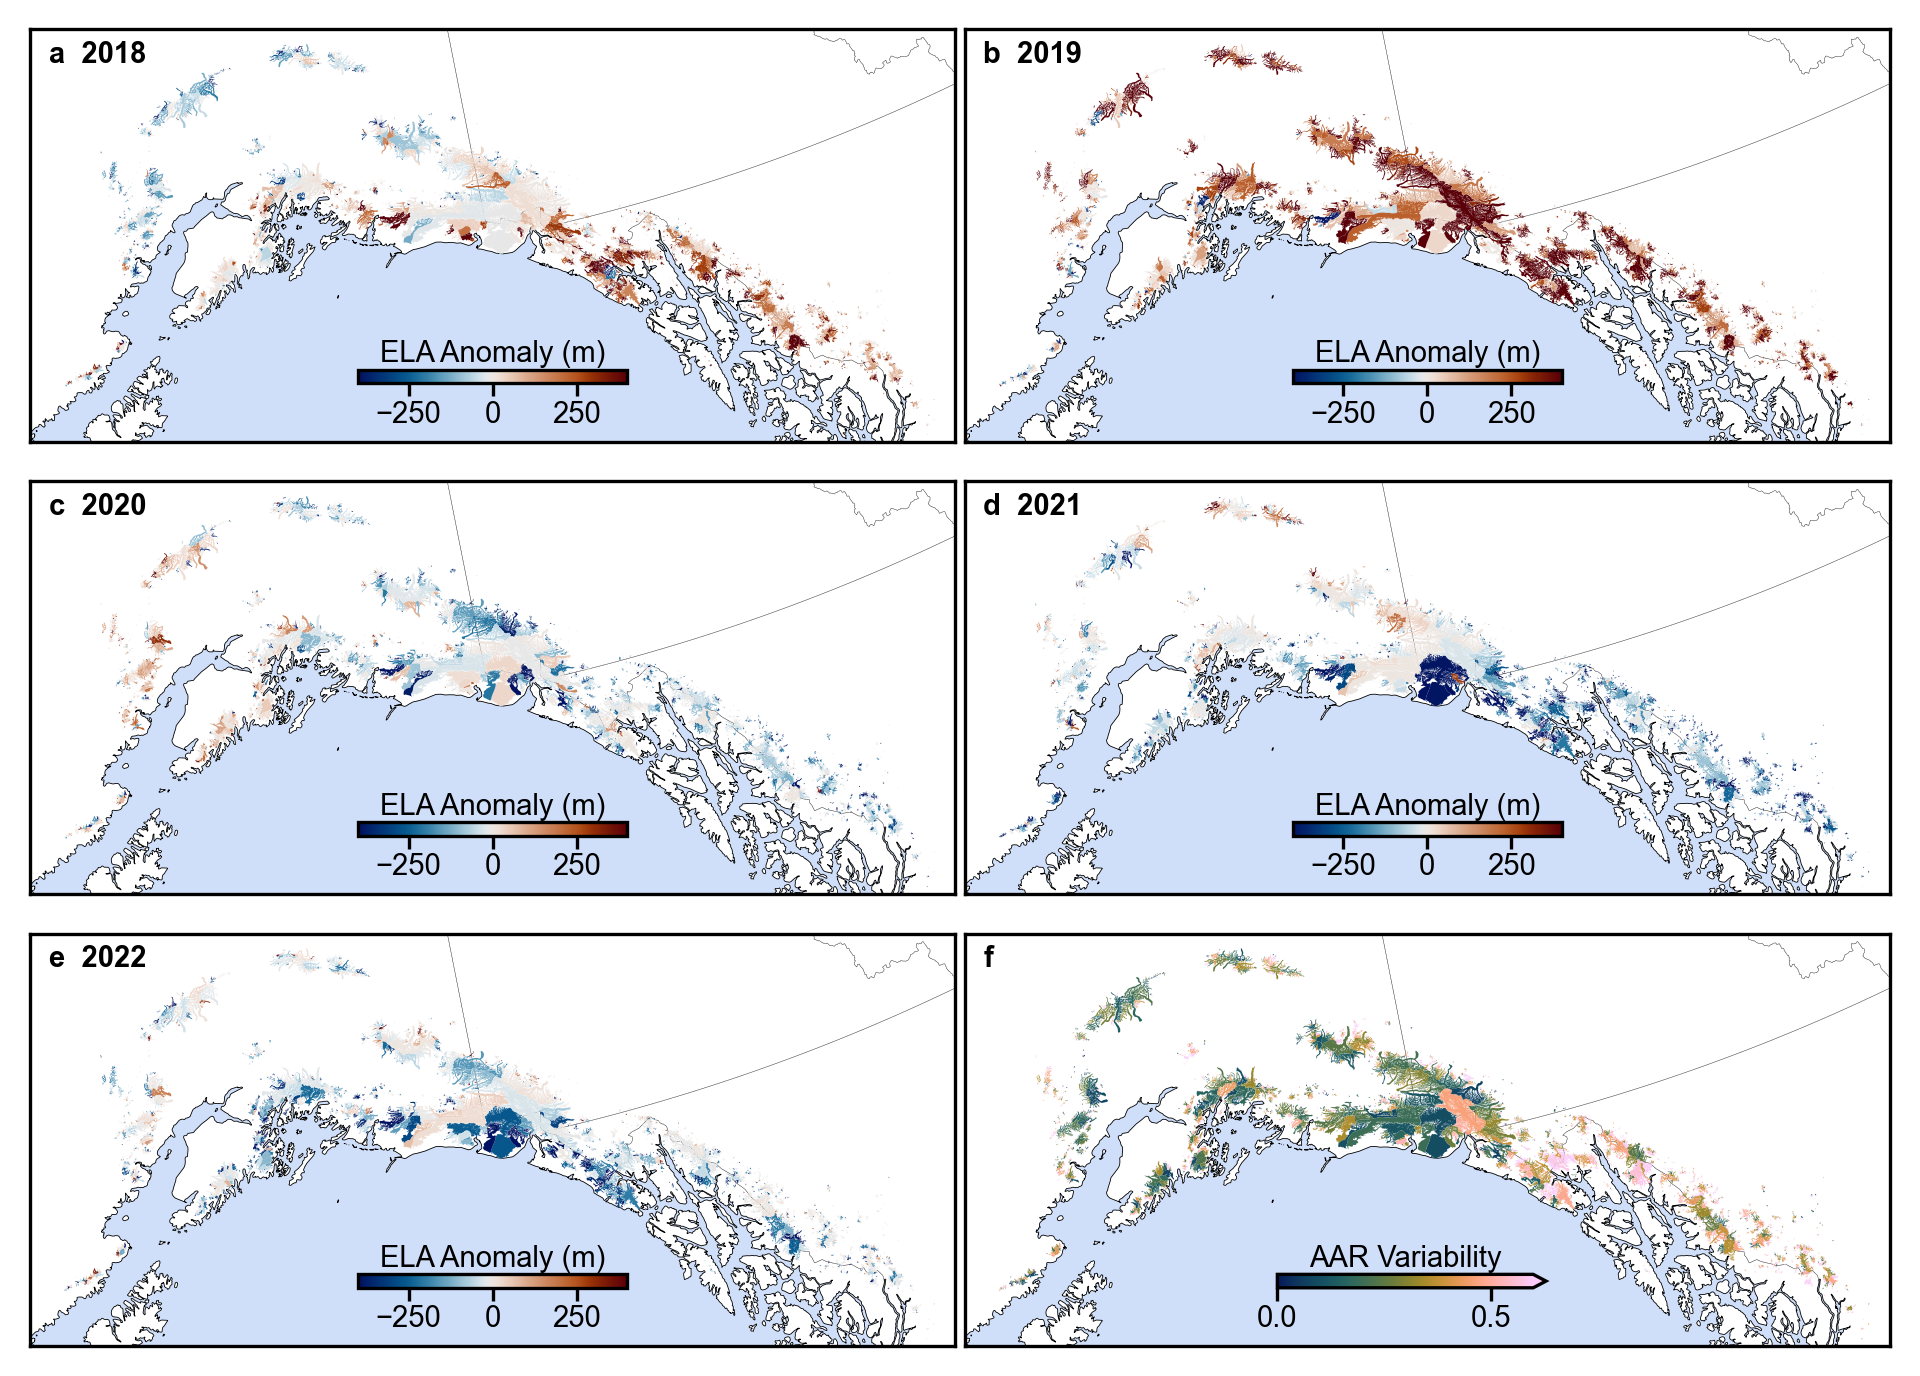

In [10]:
fig,axs = snowFun.create_annual_base_maps_rotate(width=6.5, height=5, hillshade=0, closeup=True)

ax18,ax19,ax20,ax21,ax22,axav = [a for ax in axs for a in ax] # flatten out everything
all_axs = [ax18,ax19,ax20,ax21,ax22,axav]
vmin=-399
vmax=399
cmap=cm.vik
cmap_pad = -0.16
cmap_fraction = 0.03

p18 = all_data_gdf.plot(ax=ax18, column='ela_anom_2018', zorder=10, cmap=cmap, vmin=vmin, vmax=vmax, legend=True,
                          legend_kwds={"location":'bottom', "fraction":cmap_fraction, 'pad':cmap_pad})

p19 = all_data_gdf.plot(ax=ax19, column='ela_anom_2019', zorder=10, cmap=cmap, vmin=vmin, vmax=vmax, legend=True,
                          legend_kwds={"location":'bottom', "fraction":cmap_fraction, 'pad':cmap_pad})

p20 = all_data_gdf.plot(ax=ax20, column='ela_anom_2020', zorder=10, cmap=cmap, vmin=vmin, vmax=vmax, legend=True,
                          legend_kwds={"location":'bottom', "fraction":cmap_fraction, 'pad':cmap_pad})

p21 = all_data_gdf.plot(ax=ax21, column='ela_anom_2021', zorder=10, cmap=cmap, vmin=vmin, vmax=vmax, legend=True,
                          legend_kwds={"location":'bottom', "fraction":cmap_fraction, 'pad':cmap_pad})

p22 = all_data_gdf.plot(ax=ax22, column='ela_anom_2022', zorder=10, cmap=cmap, vmin=vmin, vmax=vmax, legend=True,
                          legend_kwds={"location":'bottom', "fraction":cmap_fraction, 'pad':cmap_pad})

pav = all_data_gdf.plot(ax=axav, column='aar_range_mag', zorder=10, cmap=cm.batlow, vmin=0, vmax=0.6, legend=True,
                          legend_kwds={"location":'bottom', "fraction":cmap_fraction, 'pad':cmap_pad, 'extend':'max'})

# format colorbar in first 5 axes
for ax in fig.axes[-6:]:
    ax.tick_params(labelsize=7, length=3, pad=1)
    ax.set_xlabel('ELA Anomaly (m)', size=7, labelpad=2) 
    ax.xaxis.set_label_position('top')
    
# format colorbar in 6th 'extra' axis
for ax in fig.axes[-1:]:
    ax.tick_params(labelsize=7, length=3, pad=1)
    ax.set_xlabel('AAR Variability', size=7, labelpad=2) 
    ax.xaxis.set_label_position('top')
    
# format labels on each plot
labels = ['a  2018','b  2019','c  2020','d  2021','e  2022','f']
for i in [0,1,2,3,4,5]:
    ax = all_axs[i]
    ax.set_title("")
    ax.text(0.02, 0.92, labels[i],
            fontsize=7, weight='bold',
            transform = ax.transAxes)

# final touches
plt.tight_layout()
plt.subplots_adjust(hspace=0.01, wspace=0.01)

# save
out_path = os.path.join(folder_AGVA, 'Figures', 'annual elas', 'annual_elas_rotate_close_biggertext.png')
plt.savefig(out_path, dpi=400, bbox_inches='tight', pad_inches=0.015)

In [11]:
### o3_df analysis
    
# calculating total glacier number, glacier area, mean and median size, aa, and aar for each region
o3_df = pd.DataFrame(all_data_gdf.groupby('O3Region')['Area'].count().rename('number'))
o3_df['area'] = all_data_gdf.groupby('O3Region')['Area'].sum()
o3_df['aa'] = all_data_gdf.groupby('O3Region')['aa_avg_product'].sum()
o3_df['aar'] = o3_df['aa']/o3_df['area']

# calculate dhdt for each region
all_data_gdf['temporary'] = (all_data_gdf['Area']/all_data_gdf['O3Region_area']) * all_data_gdf['dhdt_1520']
o3_df['dhdt_1520'] = all_data_gdf.groupby('O3Region')['temporary'].sum()
all_data_gdf['temporary'] = (all_data_gdf['Area']/all_data_gdf['O3Region_area']) * all_data_gdf['dhdt_1020']
o3_df['dhdt_1020'] = all_data_gdf.groupby('O3Region')['temporary'].sum()

# calculate aar each year
for y in [2018,2019,2020,2021,2022]:
    o3_df[f'aa_{y}'] = all_data_gdf.groupby('O3Region')[f'aa_{y}'].sum()
    o3_df[f'aar_{y}'] = o3_df[f'aa_{y}']/o3_df['area']
    
### calculate average elas each year, for glaciers where ela was observed
temp = all_data_gdf[all_data_gdf[f'off_glacier_{y}']==0]
o3_df[f'ela_avg_product'] = temp.groupby('O3Region')[f'ela_avg_product'].mean()

for y in [2018,2019,2020,2021,2022]:
    # for this year, subset to valid ela obs
    temp = all_data_gdf[all_data_gdf[f'off_glacier_{y}']==0]
    o3_df[f'ela_mean_{y}'] = temp.groupby('O3Region')[f'ela_{y}'].mean()
    o3_df[f'ela_median_{y}'] = temp.groupby('O3Region')[f'ela_{y}'].median()
    
    # do the same, but only for larger glaciers (5km2 or bigger)
    temp = all_data_gdf[ (all_data_gdf[f'off_glacier_{y}']==0) & (all_data_gdf['Area']>=5) ]
    o3_df[f'ela_5km_mean_{y}'] = temp.groupby('O3Region')[f'ela_{y}'].mean()
    o3_df[f'ela_5km_median_{y}'] = temp.groupby('O3Region')[f'ela_{y}'].median()
    
    # # anomalies
    o3_df[f'ela_anom_{y}'] = o3_df[f'ela_mean_{y}'] - o3_df['ela_avg_product']
    
o3_df[f'ela_range'] = o3_df[ [f'ela_anom_{y}' for y in range(2018,2023)] ].max(axis=1) - o3_df[ [f'ela_anom_{y}' for y in range(2018,2023)] ].min(axis=1)
o3_df[f'aar_range'] = o3_df[ [f'aar_{y}' for y in range(2018,2023)] ].max(axis=1) - o3_df[ [f'aar_{y}' for y in range(2018,2023)] ].min(axis=1)

In [12]:
o3_df[ [f'ela_anom_{y}' for y in range(2018,2023)] ]
# o3_df[f'aar_range']

,ela_anom_2018,ela_anom_2019,ela_anom_2020,ela_anom_2021,ela_anom_2022
O3Region,,,,,
0,NaN,-41.566667,-90.900000,-318.650000,-202.900000
1,-197.539216,-169.882125,48.053922,-273.238658,-83.343137
2,-90.835348,-92.668500,27.694458,-65.925169,-71.503185
3,-160.934858,88.936937,3.880440,-55.229730,-105.027027
4,-150.996514,174.322885,-153.465906,-124.405797,-109.971014
5,-101.706079,384.645570,-102.091272,61.445570,-28.670886
6,-127.556452,292.508065,-124.072077,-22.778674,-23.620968
7,-158.809524,352.857143,-89.078341,-56.273292,-137.142857
8,-132.122883,-87.049052,-32.846154,-177.255437,-183.615385
